# CX 4230, Spring 2016: [02] Segregation Demo

For our first in-class exercise, we will use this [Jupyter notebook](http://jupyter.org) (formerly, "IPython notebook") to explore a simple conceptual model and simulator of _segregation phenomena_. It's based on modeling ideas explored in some depth in Thomas C. Shelling's 2006 book, [_Micromotives and macrobehaviors_](http://www.amazon.com/Micromotives-Macrobehavior-Thomas-C-Schelling/dp/0393329461).

Hello, world!

## From "fuzzy" problem to conceptual model

Recall our motivating problem, which came from this picture of Atlanta [taken from [Wikipedia](https://en.wikipedia.org/wiki/Racial_segregation_in_Atlanta)]:

![title](https://upload.wikimedia.org/wikipedia/commons/7/7a/Race_and_ethnicity_Atlanta.png)

Let's suppose the phenomenon we wish to model and simulate is as follows. Suppose the world consists of two "tribes" of individuals, referred to as "Tribe A" and "Tribe B." These tribes are geographically distributed in some fashion. Each tribe has a natural and intrinsic preference or affinity for members of the same tribe; thus, if an individual of one tribe lives in a neighborhood dominated by the other tribe, then that individual might move to a different neighborhood. Under such a process, one would expect that even if all individuals were mixed "uniformly randomly" initially, it would over time segregate.

> "Affinity" or "preference" represents a very abstract "attractive" tendency. It does _not_ necessarily imply a conscious choice.

Our initial goal is just to come up with a simple model, with as fewer parameters as possible, that (qualitatively) reproduces such behavior. We can then separately ask what "real-world" phenomena can really be modeled by such a process.

**Cellular automaton.** One kind of simple conceptual model we could apply is the general class of models known as [_cellular automata_](https://en.wikipedia.org/wiki/Cellular_automaton) (plural). The basic idea of any cellular automaton (singular) is to model a system by a geometric collection of discrete cells, where each cell can be in one of a finite number of possible states; the system evolves in discrete time steps, where at each time step the state of every cell might change according to a state-transition rule.

## A formal conceptual model of segregation based on a cellular automaton

Let's use a cellular automaton as the conceptual model for the "segregation system." Using Python, we will simultaneously build the _simulator_ for that conceptual model.

### Setting up the initial world

Let's suppose the members of our two tribes ("A" and "B") live in a physical world, which we represent by a 2-D Cartesian grid of cells of size $(m+2) \times (n+2)$. Each cell has a location, given by a pair of integers $(i, j)$, where $0 \leq i < m+2$ and $0 \leq j < n+2$.

Why the "+2"? The world will actually have two parts: an "interior," where members of the two tribes can live, and a "boundary layer," which is a 1-cell deep wall that encloses the interior cells. More formally, the interior cells are the $(i, j)$ such that $1 \leq i \leq m$ and $1 \leq j \leq n$; all remaining cells comprise the boundary. No one can live in the boundary layer; as it is a wall, it will (conceptually) prevent migration out of the world.

In [1]:
M, N = 10, 10  # Dimensions of the "physical" world are (M+2) x (N+2)

Just one member of some tribe may occupy a cell at any moment in time. Time increases monotonically in discrete integer steps, starting at $t = 0$.

Formally, let's encode these facts by defining a population grid, which is a collection of population cells at time $t$, $G(t) \equiv \{g_{ij}(t)\}$. Each cell takes on one of three integer values: $g_{ij}(t) \in \{-1, 0, +1\}$, where a $+1$ means a member of tribe A occupies cell $(i, j)$ at time $t$; a $-1$ means a member of tribe B occupies the cell; and a $0$ means the cell is empty.

> Recall that no one can live in the wall, so its cells are always zero.

In [2]:
# Possible population cell states:
EMPTY = 0
TRIBE_A = 1
TRIBE_B = -1

We need to initialize this world. Let's do so probabilistically; that is, let's populate the world randomly according to some assumed distribution.

> To see if the evolution of this world is sensitive to properties of this distribution, we can change the population parameters or distributions, do experiments (i.e., simulations), and analyze the results. Later in the semester, we will talk about _input modeling_ and _output modeling_, which are the principles and techniques for how to do our simulations systematically so we can interpret the results.

At time $t=0$, suppose the chance that a cell is occupied is given by a Bernoulli trial, which is independent of cell's location. That is, for any interior cell $(i, j)$ such that $1 \leq i \leq m$ and $1 \leq j \leq n$,

$$
  Pr[g_{ij}(0) = \pm 1] \equiv \rho,
$$

where $\rho \in [0, 1]$. Note that this implies the probability that the cell is empty is $Pr[g_{ij}(0) = 0] = 1 - \rho$.

If the cell is occupied, let's further suppose that tribe A occupies the cell with probability $\alpha$. That is, the conditional probability,

$$
  Pr[g_{ij}(0) = +1|g_{ij}(0) = \pm 1] \equiv \alpha .
$$

From these givens and facts of elementary probability, we may conclude that for all _interior_ cells,

$$
  Pr[g_{ij}(0) = k]
    = \left\{\begin{array}{ll}
                 1 - \rho & \mathrm{if\ } k = 0 \\
              \rho \alpha & \mathrm{if\ } k = +1 \\
        \rho (1 - \alpha) & \mathrm{if\ } k = -1
      \end{array}\right..
$$

With these definitions, we can build the initial world.

In [3]:
PROB_OCCUPIED = 0.5 # Probability that a cell is occupied
COND_PROB_A = 2.0/3 # Cond. prob. that occupied cell is +1 (tribe "A")

In [4]:
import numpy as np
np.random.seed (1601134230) # Fixed seed, for debugging

> [Numpy](http://www.numpy.org) is a multidimensional array library, with special support for fast matrix computations. It is part of a larger Python package of scientific and numerical computing tools called [Scipy](http://www.scipy.org). We will use bits and pieces of both libraries throughout the class.

In [5]:
def create_pop_grid (m, n, pr_occupied, pr_one):
    """
    Returns an (m+2) x (n+2) grid of integer cells, representing
    the population map of an abstract "world."
    
    Each cell contains one of three possible values: {-1, 0, +1}.
    The boundaries are set to 0, i.e., the world is "padded."
    
    In the interior, the probability that a cell is non-zero is
    pr_occupied. Cells are independent. The conditional
    probability that an occupied cell is +1 given that it is
    occupied is pr_one.
    """
    
    dims = (m+2, n+2)
    
    pr_a = pr_occupied * pr_one
    pr_b = pr_occupied * (1.0 - pr_one)
    pr_empty = (1.0 - pr_occupied)
    
    possible_values = np.array ([EMPTY, TRIBE_A, TRIBE_B])
    pr_dist = np.array ([pr_empty, pr_a, pr_b])
    
    grid = np.random.choice (possible_values, size=dims, p=pr_dist)
    
    # Fix the boundary
    grid[  0,   :] = EMPTY
    grid[m+1,   :] = EMPTY
    grid[  :,   0] = EMPTY
    grid[  :, n+1] = EMPTY
    
    return grid

In [6]:
peeps = create_pop_grid (M, N, PROB_OCCUPIED, COND_PROB_A)
print (peeps)
print (np.count_nonzero (peeps == EMPTY) - 22)


[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  1  0  1  0]
 [ 0  1  0 -1  1  0  0  0 -1  1  1  0]
 [ 0  1  0 -1 -1  0 -1  0  1  1 -1  0]
 [ 0  1  1  0  0  0  0 -1  1  1 -1  0]
 [ 0  1  0  0  0  0  1  1  0  1  0  0]
 [ 0 -1 -1  0  0  0  1  0  0  0  1  0]
 [ 0  1  0  0  1  0  1  0  0  1  0  0]
 [ 0 -1  0  1  0 -1  1  0  0  1 -1  0]
 [ 0  0  0  0  1  0  1  1 -1  1  0  0]
 [ 0  0 -1  0  1 -1  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
71


> [Matplotlib](http://matplotlib.org/) is another handy package, used for scientific plotting. Among other things, we can use it to plot the state of the world.

In [7]:
import matplotlib.pyplot as plt # Core plotting support
%matplotlib inline

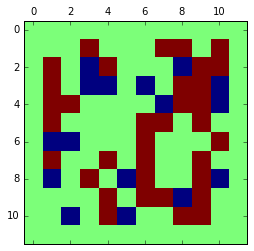

In [8]:
def show_grid (grid):
    plt.matshow (grid)
    
show_grid (peeps)

**Aside: Python slicing-fu.** If you know Fortran, MATLAB, Python, or Go, then you have probably seen and used [_array slicing_](https://en.wikipedia.org/wiki/Array_slicing), which is a handy notation for referring to a collection of elements of a (multidimensional) array. Since some of you are just learning Python, here is a quick demo to illustrate some basic features of Python's [array slicing syntax](https://docs.python.org/2/tutorial/introduction.html), as well as how it works specifically for [slicing Numpy arrays](http://docs.scipy.org/doc/numpy/reference/arrays.indexing.html).

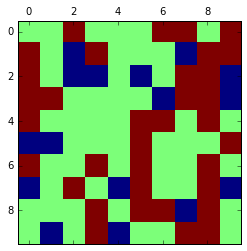

In [9]:
show_grid (peeps[1:-1, 1:-1])

In [10]:
def normalize_neighborhoods (grid):
    # Given a grid of cells, normalize the value of each
    # grid cell by the count of its nearest neighbors.
    norm_grid = np.zeros (grid.shape)
    
    # Interior
    norm_grid[1:-1, 1:-1] = grid[1:-1, 1:-1] / 9
    
    # Edges
    norm_grid[1:-1, 0] = grid[1:-1, 0] / 6
    norm_grid[1:-1, -1] = grid[1:-1, -1] / 6
    norm_grid[0, 1:-1] = grid[0, 1:-1] / 6
    norm_grid[-1, 1:-1] = grid[-1, 1:-1] / 6
    
    # Corners
    norm_grid[0, 0] = grid[0, 0] / 4
    norm_grid[0, -1] = grid[0, -1] / 4
    norm_grid[-1, 1] = grid[-1, 0] / 4
    norm_grid[-1, -1] = grid[-1, -1] / 4
    
    return norm_grid

### Dominance is bliss: Measuring "happiness"

Having set up the world, the next step is to model the mobility of the cells conceptually as _state transitions_ of the cellular automaton.

At a high-level, we wish to define the function,

$$
  G(t+1) \leftarrow F(G(t)).
$$

Intuitively, you might hypothesize that individuals prefer to be in neighborhoods that have more members of the same tribe. So, our process might be to first measure, for each cell $(i, j)$, some property that we can use to decide whether the occupant wants to move.

To define this property, let's start by defining the "character" or "color" $c_{ij}(t)$ of its neighborhood at time $t$. Let's adopt a convention that low values of color correspond to dissimilarity, and high values similarity.

Define the _neighborhood_ $\mathcal{N}_{ij}$ of cell $(i, j)$ to be the collection of cells right next to it, including $(i, j)$. That is,

$$
  \mathcal{N}_{ij} \equiv \{(i', j') : |i' - i|, |j' - j| \leq 1\}.
$$

Let's measure the _raw color_ $c_{ij}(t)$ of $(i, j)$ at time $t$ as the sum of the population values in its neighorhood:

$$
  c_{ij}(t) \equiv
    \displaystyle \sum_{(r, s) \in \mathcal{N}_{ij}} g_{rs}(t).
$$

If the neighborhood has the same number of +1 and -1 values, then its color is zero. Otherwise, the sign of $c_{ij}(t)$ indicates whether the neighborhood has more members of tribe A (sum is positive) or B (sum is negative).

For our conceptual model, we will be interested not in the raw color, but a normalized version of it, where the normalization factor is just the size of the neighborhood:

$$
  \hat{c}_{ij}(t) \equiv \frac{c_{ij}(t)}
                              {\left| \mathcal{N}_{ij} \right|}.
$$

**Exercise.** Define a Python function, `measure_color(G)`, which takes an  grid `G` as input and returns a grid `C` of (raw) colors. Assume that `G` has a boundary layer (wall).

> In the skeleton below, `measure_color()` takes an optional argument, `normalize`, which when `True` asks for the _normalized_ color instead. This normalization code has been filled in for you. Your task is to replace the `pass` statement with code to compute the color according to the conceptual model.

In [14]:
def measure_color (G, normalize=False):
    C = np.zeros (G.shape, dtype=G.dtype)
    
    # @YOUSE: Compute the colors C from grid G
            
    C[1:-1, 1:-1] += G[0:-2, 0:-2] + G[0:-2, 1:-1] + G[0:-2, 2:]
    C[1:-1, 1:-1] += G[1:-1, 0:-2] + G[1:-1, 1:-1] + G[1:-1, 2:]
    C[1:-1, 1:-1] += G[2:  , 0:-2] + G[2:  , 1:-1] + G[2:  , 2:]

    
    if normalize:
        C = C.astype (float)
        C[1:-1, 1:-1] = normalize_neighborhoods (C[1:-1, 1:-1])
        
    return C

In [15]:
# Some test code:
raw_color_grid = measure_color (peeps)
norm_color_grid = measure_color (peeps, normalize=True)

print ("\nPopulation grid:\n", peeps)
print ("\nRaw color grid:\n", raw_color_grid)

np.set_printoptions (precision=1, linewidth=999)
print ("\nNormalized color grid:\n", norm_color_grid)
print ("\nNormalized color grid (only for occupied cells:)\n",
       np.multiply (norm_color_grid, peeps != EMPTY))


Population grid:
 [[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  1  0  1  0]
 [ 0  1  0 -1  1  0  0  0 -1  1  1  0]
 [ 0  1  0 -1 -1  0 -1  0  1  1 -1  0]
 [ 0  1  1  0  0  0  0 -1  1  1 -1  0]
 [ 0  1  0  0  0  0  1  1  0  1  0  0]
 [ 0 -1 -1  0  0  0  1  0  0  0  1  0]
 [ 0  1  0  0  1  0  1  0  0  1  0  0]
 [ 0 -1  0  1  0 -1  1  0  0  1 -1  0]
 [ 0  0  0  0  1  0  1  1 -1  1  0  0]
 [ 0  0 -1  0  1 -1  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]

Raw color grid:
 [[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  1  1  1  1  1  2  3  3  0]
 [ 0  2  1 -1 -1 -1  0  1  4  4  3  0]
 [ 0  4  2 -1 -2 -1 -2 -1  3  3  2  0]
 [ 0  4  3 -1 -2 -1  0  2  5  3  1  0]
 [ 0  1  1  0  0  2  2  3  3  3  2  0]
 [ 0  0  0  0  1  4  4  4  3  3  3  0]
 [ 0 -2 -1  1  1  3  2  3  2  2  2  0]
 [ 0  0  1  3  2  4  3  3  3  1  2  0]
 [ 0 -2 -1  2  1  2  1  3  4  2  2  0]
 [ 0 -1 -1  1  1  2  1  2  3  2  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]

Normalized color grid:
 

Given the normalized color measurement, we can define a condition in which an individual _wants_ to move to a different neighborhood.

Suppose $g_{ij}(t)$ is occupied. Then, let the _happiness_ at $(i, j)$ be

$$
  h_{ij}(t) \equiv g_{ij}(t) \cdot \hat{c}_{ij}(t).
$$

This value is positive if $g_{ij}(t)$ and $\hat{c}_{ij}(t)$ have the same sign, or negative otherwise. Thus, higher values of $h_{ij}(t)$ indicate that the tribe of $g_{ij}(t)$ is more prevalent. This suggests a simple rule for determining whether the occupant of cell $(i, j)$ is unhappy, namely, when $h_{ij}(t) < \theta$ for some given threshold $\theta$.

**Exercise.** Suppose you are given

* a population grid, `G`;
* a _normalized_ color grid, `C`;
* and a threshold, `theta`.

Then, define a function, `get_unhappy_grid(G, C, theta)`, which returns a new grid `G_unhappy` which has `G_unhappy[i, j] == G[i, j]` wherever an occupant `G[i, j]` is unhappy, i.e., has a $h_{ij}$ strictly less than $\theta$; everywhere else, `G_unhappy` is zero.

In [18]:
UNHAPPY_COLOR_THRESHOLD = 0

def get_unhappy_grid (G, C, threshold=UNHAPPY_COLOR_THRESHOLD):
    # @YOUSE: Compute G_unhappy
    H = np.multiply (G, C)
    G_unhappy = np.multiply (G, H < threshold)
    #G_unhappy = np.ma.masked_where (H < threshold, G)
    
    return G_unhappy

In [19]:
unhappy_campers = get_unhappy_grid (peeps, norm_color_grid)

print ("\nUnhappy campers:\n", unhappy_campers)


Unhappy campers:
 [[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]


Now that we know who is unhappy, we can finish defining the "dynamics" of our state transition function, $F(G(t))$.

Let's start by getting a list of everyone who is unhappy, separated by tribe.

In [20]:
def get_locations (condition_grid):
    """
    Given a grid of True/False values, returns a
    list of tuples [..., (i, j), ...], where each
    tuple is the location of a True value.
    """
    locs = np.nonzero (condition_grid)
    return list (zip (locs[0], locs[1]))

# Determine the positions of the members of tribes
# A (+1) and B (-1) who are unhappy
locs_unhappy_A = get_locations (unhappy_campers == TRIBE_A)
locs_unhappy_B = get_locations (unhappy_campers == TRIBE_B)

print ("\nPositions of unhappy members of tribe A:\n", locs_unhappy_A)
print ("\nPositions of unhappy members of tribe B:\n", locs_unhappy_B)


Positions of unhappy members of tribe A:
 [(2, 4), (7, 1)]

Positions of unhappy members of tribe B:
 [(2, 8), (3, 10), (4, 7), (4, 10), (8, 5), (8, 10), (9, 8), (10, 5)]


Next, let's get a list of empty cells, i.e., "available real estate" for occupants who want to move out of their neighborhoods.

In [21]:
def is_free_grid (pop_grid):
    free_spaces = np.zeros (pop_grid.shape, dtype=bool)
    free_spaces[1:-1, 1:-1] = (pop_grid[1:-1, 1:-1] == EMPTY)
    return free_spaces

avail_grid = is_free_grid (peeps)

print (peeps)
print ("\nAvailable real estate:\n", avail_grid)

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  1  0  1  0]
 [ 0  1  0 -1  1  0  0  0 -1  1  1  0]
 [ 0  1  0 -1 -1  0 -1  0  1  1 -1  0]
 [ 0  1  1  0  0  0  0 -1  1  1 -1  0]
 [ 0  1  0  0  0  0  1  1  0  1  0  0]
 [ 0 -1 -1  0  0  0  1  0  0  0  1  0]
 [ 0  1  0  0  1  0  1  0  0  1  0  0]
 [ 0 -1  0  1  0 -1  1  0  0  1 -1  0]
 [ 0  0  0  0  1  0  1  1 -1  1  0  0]
 [ 0  0 -1  0  1 -1  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]

Available real estate:
 [[False False False False False False False False False False False False]
 [False  True  True False  True  True  True False False  True False False]
 [False False  True False False  True  True  True False False False False]
 [False False  True False False  True False  True False False False False]
 [False False False  True  True  True  True False False False False False]
 [False False  True  True  True  True False False  True False  True False]
 [False False False  True  True  True False  True  True 

Given the available real estate, we can then determine which ones each tribe might find appealing.

Let's start with tribe A. Define those locations to be any empty cell $(i, j)$ such that the $\hat{c}_{ij}(t) > \theta$, i.e., the normalized color of the neighborhood is above the unhappiness threshold.

In [24]:
appeals_to_A = (norm_color_grid >= UNHAPPY_COLOR_THRESHOLD)
locs_appeal_to_A = get_locations (avail_grid & appeals_to_A)
print ("\nFree locations that might appeal to A:\n", locs_appeal_to_A)


Free locations that might appeal to A:
 [(1, 1), (1, 2), (1, 4), (1, 5), (1, 6), (1, 9), (2, 2), (2, 6), (2, 7), (3, 2), (4, 6), (5, 2), (5, 3), (5, 4), (5, 5), (5, 8), (5, 10), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (7, 3), (7, 5), (7, 7), (7, 8), (7, 10), (8, 2), (8, 4), (8, 7), (8, 8), (9, 3), (9, 5), (9, 10), (10, 1), (10, 3), (10, 6), (10, 7), (10, 10)]


**Exercise.** What is an analogous condition for tribe B? That is, define a condition and then compute `locs_appeal_to_B`, a list of locations (tuples) that might be available and appealing to tribe B.

In [23]:
# @YOUSE: Compute locs_appeal_to_B, analogous to locs_appeal_to_A above
appeals_to_B = (-norm_color_grid >= UNHAPPY_COLOR_THRESHOLD)
locs_appeal_to_B = get_locations (avail_grid & appeals_to_B)

# Test code
print ("\nFree locations that might appeal to B:\n", locs_appeal_to_B)


Free locations that might appeal to B:
 [(2, 5), (2, 6), (3, 5), (3, 7), (4, 3), (4, 4), (4, 5), (4, 6), (5, 3), (5, 4), (6, 3), (7, 2), (9, 1), (9, 2), (10, 1)]


Given members of a tribe that want to move and a list of possible locations, the last step is to execute the moves.

Our procedure will be the following. Given the list of destinations (i.e., locations that are both available _and_ appealing), we will move as many unhappy members of the tribe to these destinations as possible. (The reason for "as possible" is that there may be fewer destinations than unhappy campers.)

The following helper routine executes a batch of random swaps on a grid, given "source" and "target" indices.

**Exercise.** Make sure you understand what this function does before moving on.

In [25]:
import random # Python's built-in random number generator module

def swap_grid_random (G, locs_x, locs_y):
    """
    Given a grid and two possible collections of locations, X and Y,
    this routine randomly swaps as many locations from X with those
    from Y. This routine performs the swaps *in-place*, that is, it
    modifies grid directly.
    """
    
    # Max swaps possible
    n = min (len (locs_x), len (locs_y))
    
    # Choose random entries to swap
    locs_x_to_swap = random.sample (locs_x, n)
    locs_y_to_swap = random.sample (locs_y, n)
    
    # Execute swaps
    for ((xi, xj), (yi, yj)) in zip (locs_x_to_swap, locs_y_to_swap):
        G[xi, xj], G[yi, yj] = G[yi, yj], G[xi, xj]
        
    return G

**Exercise.** Use the above function to execute one round of moves of unhappy campers for both tribes.

Tribe A: before = 35 and after = 35
Tribe B: before = 16 and after = 16


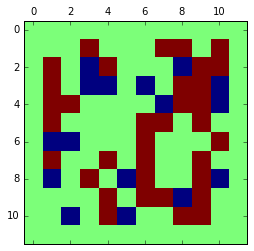

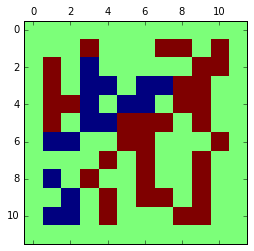

In [26]:
new_peeps = np.copy (peeps)

# @YOUSE: Move as many unhappy campers as possible.
# Store your result in `new_peeps`.

swap_grid_random (new_peeps, locs_unhappy_A, locs_appeal_to_A)
swap_grid_random (new_peeps, locs_unhappy_B, locs_appeal_to_B)

# Sanity check: Make sure population counts have not changed!
print ("Tribe A: before =", np.count_nonzero (peeps == TRIBE_A),
       "and after =", np.count_nonzero (new_peeps == TRIBE_A))
print ("Tribe B: before =", np.count_nonzero (peeps == TRIBE_B),
       "and after =", np.count_nonzero (new_peeps == TRIBE_B))

show_grid (peeps)
show_grid (new_peeps)